# 晶体结构预测评测 Notebook

本notebook用于：
1. 读取submission.csv（CIF格式）预测结果
2. 读取A_sample.pkl中的ground truth
3. 计算RMSD等评测指标
4. 可视化分析结果

## 1. 导入必要的库

In [25]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pymatgen.core import Structure, Lattice
from pymatgen.io.cif import CifParser
from pymatgen.analysis.structure_matcher import StructureMatcher
from scipy.spatial.distance import cdist
from tqdm.auto import tqdm
import warnings
import io
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("库导入成功！")

库导入成功！


## 2. 数据加载

In [26]:
# 文件路径
SUBMISSION_FILE = "submission.csv"
GROUND_TRUTH_FILE = "data/A_sample/A_sample.pkl"

# 检查文件是否存在
if not Path(SUBMISSION_FILE).exists():
    print(f"警告: {SUBMISSION_FILE} 不存在！请先运行 inference.ipynb")
else:
    print(f"✓ 找到提交文件: {SUBMISSION_FILE}")

if not Path(GROUND_TRUTH_FILE).exists():
    print(f"错误: {GROUND_TRUTH_FILE} 不存在！")
else:
    print(f"✓ 找到ground truth文件: {GROUND_TRUTH_FILE}")

✓ 找到提交文件: submission.csv
✓ 找到ground truth文件: data/A_sample/A_sample.pkl


In [27]:
# 加载submission.csv
try:
    submission_df = pd.read_csv(SUBMISSION_FILE)
    print(f"\n加载了 {len(submission_df)} 个预测结果")
    print(f"列名: {submission_df.columns.tolist()}")
    print("\n前3行数据（CIF内容截断显示）:")
    for idx, row in submission_df.head(3).iterrows():
        print(f"  ID: {row['ID']}, CIF长度: {len(row['cif'])} 字符")
except Exception as e:
    print(f"加载submission文件失败: {e}")
    submission_df = None


加载了 200 个预测结果
列名: ['ID', 'cif']

前3行数据（CIF内容截断显示）:
  ID: A-329, CIF长度: 1720 字符
  ID: A-1447, CIF长度: 872 字符
  ID: A-1150, CIF长度: 1184 字符


In [28]:
# 加载ground truth
with open(GROUND_TRUTH_FILE, 'rb') as f:
    gt_df = pickle.load(f)

print(f"\n加载了 {len(gt_df)} 个ground truth样本")
print(f"列名: {gt_df.columns.tolist()}")
print("\n前3个样本的ID:")
print(gt_df['id'].head(3).tolist())


加载了 200 个ground truth样本
列名: ['id', 'structure', 'niggli_structure', 'primitive_structure', 'pxrd', 'niggli_comp', 'primitive_comp', 'atom_types', 'num_atoms', 'lattice_matrix', 'frac_coords']

前3个样本的ID:
['A-329', 'A-1447', 'A-1150']


## 3. 解析CIF格式

In [29]:
def parse_cif_string(cif_str):
    """
    从CIF字符串解析晶体结构
    
    Args:
        cif_str: CIF格式的字符串
    
    Returns:
        Structure对象或None（如果解析失败）
    """
    try:
        # 将CIF字符串转换为文件流
        cif_io = io.StringIO(cif_str)
        parser = CifParser(cif_io)
        structures = parser.get_structures()
        
        if structures:
            return structures[0]  # 返回第一个结构
        else:
            return None
    except Exception as e:
        print(f"解析CIF失败: {e}")
        return None

def extract_structure_info(structure):
    """
    从Structure对象提取信息
    
    Args:
        structure: pymatgen Structure对象
    
    Returns:
        dict: 包含晶格矩阵、原子类型、分数坐标等信息
    """
    if structure is None:
        return None
    
    return {
        'lattice_matrix': structure.lattice.matrix,
        'atom_types': [site.specie.Z for site in structure],
        'frac_coords': structure.frac_coords,
        'num_atoms': len(structure),
        'volume': structure.volume,
        'lattice_params': {
            'a': structure.lattice.a,
            'b': structure.lattice.b,
            'c': structure.lattice.c,
            'alpha': structure.lattice.alpha,
            'beta': structure.lattice.beta,
            'gamma': structure.lattice.gamma
        }
    }

In [30]:
# 解析所有预测结构
if submission_df is not None:
    print("解析预测结构（从CIF格式）...")
    predictions = []
    
    for idx, row in tqdm(submission_df.iterrows(), total=len(submission_df), desc="解析CIF"):
        try:
            # 解析CIF字符串
            structure = parse_cif_string(row['cif'])
            
            if structure is not None:
                # 提取结构信息
                info = extract_structure_info(structure)
                info['id'] = row['ID']
                predictions.append(info)
            else:
                print(f"警告: 无法解析 {row['ID']} 的CIF")
        except Exception as e:
            print(f"处理样本 {row['ID']} 失败: {e}")
    
    print(f"\n成功解析 {len(predictions)} 个预测结构")
else:
    predictions = []

解析预测结构（从CIF格式）...


解析CIF:   0%|          | 0/200 [00:00<?, ?it/s]

解析CIF失败: Invalid CIF file with no structures!
警告: 无法解析 A-1500 的CIF
解析CIF失败: Invalid CIF file with no structures!
警告: 无法解析 A-33 的CIF

成功解析 198 个预测结构


## 4. RMSD计算

In [31]:
def calculate_rmsd_with_matcher(pred_struct, gt_struct):
    """
    使用StructureMatcher计算RMSD
    
    Args:
        pred_struct: 预测的Structure对象
        gt_struct: ground truth的Structure对象
    
    Returns:
        float: RMSD值，如果匹配失败返回np.inf
    """
    try:
        # 使用StructureMatcher进行匹配
        matcher = StructureMatcher(
            ltol=0.2,  # 晶格长度容忍度
            stol=0.3,  # 原子位置容忍度
            angle_tol=5  # 角度容忍度
        )
        
        # 尝试匹配结构
        is_match = matcher.fit(pred_struct, gt_struct)
        
        if is_match:
            # 获取RMSD
            rms = matcher.get_rms_dist(pred_struct, gt_struct)
            if rms is not None:
                return rms[0]  # 返回RMSD值
        
        # 如果匹配失败，计算简单的RMSD
        return calculate_simple_rmsd(pred_struct, gt_struct)
        
    except Exception as e:
        return np.inf

def calculate_simple_rmsd(pred_struct, gt_struct):
    """
    计算简单的RMSD（不考虑对称性）
    """
    try:
        if len(pred_struct) != len(gt_struct):
            return np.inf
        
        # 获取笛卡尔坐标
        pred_cart = pred_struct.cart_coords
        gt_cart = gt_struct.cart_coords
        
        # 计算最小RMSD（考虑原子顺序可能不同）
        if len(pred_cart) <= 20:  # 对于小结构，尝试所有排列
            distances = cdist(pred_cart, gt_cart)
            # 使用Hungarian算法找最优匹配
            from scipy.optimize import linear_sum_assignment
            row_ind, col_ind = linear_sum_assignment(distances)
            rmsd = np.sqrt(np.mean(distances[row_ind, col_ind]**2))
        else:
            # 对于大结构，假设原子顺序相同
            diff = pred_cart - gt_cart
            rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
        
        return rmsd
    except Exception:
        return np.inf

In [32]:
# 计算所有样本的RMSD
rmsd_results = []

if predictions:
    print("计算RMSD...")
    
    for pred in tqdm(predictions, desc="计算RMSD"):
        # 找到对应的ground truth
        gt_row = gt_df[gt_df['id'] == pred['id']]
        
        if len(gt_row) == 0:
            print(f"警告: 未找到样本 {pred['id']} 的ground truth")
            continue
        
        gt_row = gt_row.iloc[0]
        
        try:
            # 创建Structure对象
            pred_structure = Structure(
                lattice=Lattice(pred['lattice_matrix']),
                species=[int(z) for z in pred['atom_types']],
                coords=pred['frac_coords'],
                coords_are_cartesian=False
            )
            
            # Ground truth可能已经是Structure对象
            if hasattr(gt_row, 'niggli_structure') and gt_row['niggli_structure'] is not None:
                gt_structure = gt_row['niggli_structure']
            else:
                # 从数据创建Structure
                gt_structure = Structure(
                    lattice=Lattice(gt_row['lattice_matrix']),
                    species=gt_row['atom_types'][:gt_row['num_atoms']],
                    coords=gt_row['frac_coords'][:gt_row['num_atoms']],
                    coords_are_cartesian=False
                )
            
            # 计算RMSD
            rmsd = calculate_rmsd_with_matcher(pred_structure, gt_structure)
            
            rmsd_results.append({
                'id': pred['id'],
                'rmsd': rmsd,
                'num_atoms': pred['num_atoms'],
                'composition': gt_row['niggli_comp'],
                'volume_diff': abs(pred['volume'] - gt_structure.volume) if 'volume' in pred else 0
            })
            
        except Exception as e:
            print(f"计算样本 {pred['id']} 的RMSD失败: {e}")
    
    rmsd_df = pd.DataFrame(rmsd_results)
    print(f"\n成功计算 {len(rmsd_df)} 个样本的RMSD")
else:
    print("没有预测结果，跳过RMSD计算")
    rmsd_df = pd.DataFrame()

计算RMSD...


计算RMSD:   0%|          | 0/198 [00:00<?, ?it/s]


成功计算 198 个样本的RMSD


## 5. 统计分析

In [33]:
if not rmsd_df.empty:
    print("="*60)
    print("RMSD统计分析")
    print("="*60)
    
    # 过滤掉无效的RMSD值
    valid_rmsd = rmsd_df[rmsd_df['rmsd'] != np.inf]
    invalid_count = len(rmsd_df) - len(valid_rmsd)
    
    print(f"\n有效样本数: {len(valid_rmsd)}")
    print(f"无效样本数: {invalid_count}")
    
    if not valid_rmsd.empty:
        print(f"\nRMSD统计（有效样本）:")
        print(valid_rmsd['rmsd'].describe())
        
        # 计算成功率（RMSD < 阈值）
        thresholds = [0.5, 1.0, 2.0, 5.0]
        print(f"\n成功率（不同RMSD阈值）:")
        for threshold in thresholds:
            success_rate = (valid_rmsd['rmsd'] < threshold).mean() * 100
            count = (valid_rmsd['rmsd'] < threshold).sum()
            print(f"  RMSD < {threshold:3.1f} Å: {success_rate:6.2f}% ({count}/{len(valid_rmsd)})")
        
        # 按原子数分组分析
        print(f"\n按原子数分组的RMSD均值:")
        atom_groups = valid_rmsd.groupby('num_atoms')['rmsd'].agg(['mean', 'std', 'count'])
        print(atom_groups.head(10))
else:
    print("没有RMSD结果可分析")

RMSD统计分析

有效样本数: 133
无效样本数: 65

RMSD统计（有效样本）:
count    133.000000
mean       7.167396
std        2.584235
min        3.004126
25%        5.385795
50%        6.776371
75%        8.353797
max       16.264846
Name: rmsd, dtype: float64

成功率（不同RMSD阈值）:
  RMSD < 0.5 Å:   0.00% (0/133)
  RMSD < 1.0 Å:   0.00% (0/133)
  RMSD < 2.0 Å:   0.00% (0/133)
  RMSD < 5.0 Å:  19.55% (26/133)

按原子数分组的RMSD均值:
               mean       std  count
num_atoms                           
4          6.146067       NaN      1
5          5.853703  2.169235      6
6          5.853370  1.070054     15
7          4.798105       NaN      1
8          6.188992  2.508531     13
9          6.338116  1.651375      7
10         6.120117  1.295085     11
11         4.933254  1.442716      2
12         6.462669  2.245724      5
14         8.214670  2.653997     11


## 6. 可视化分析

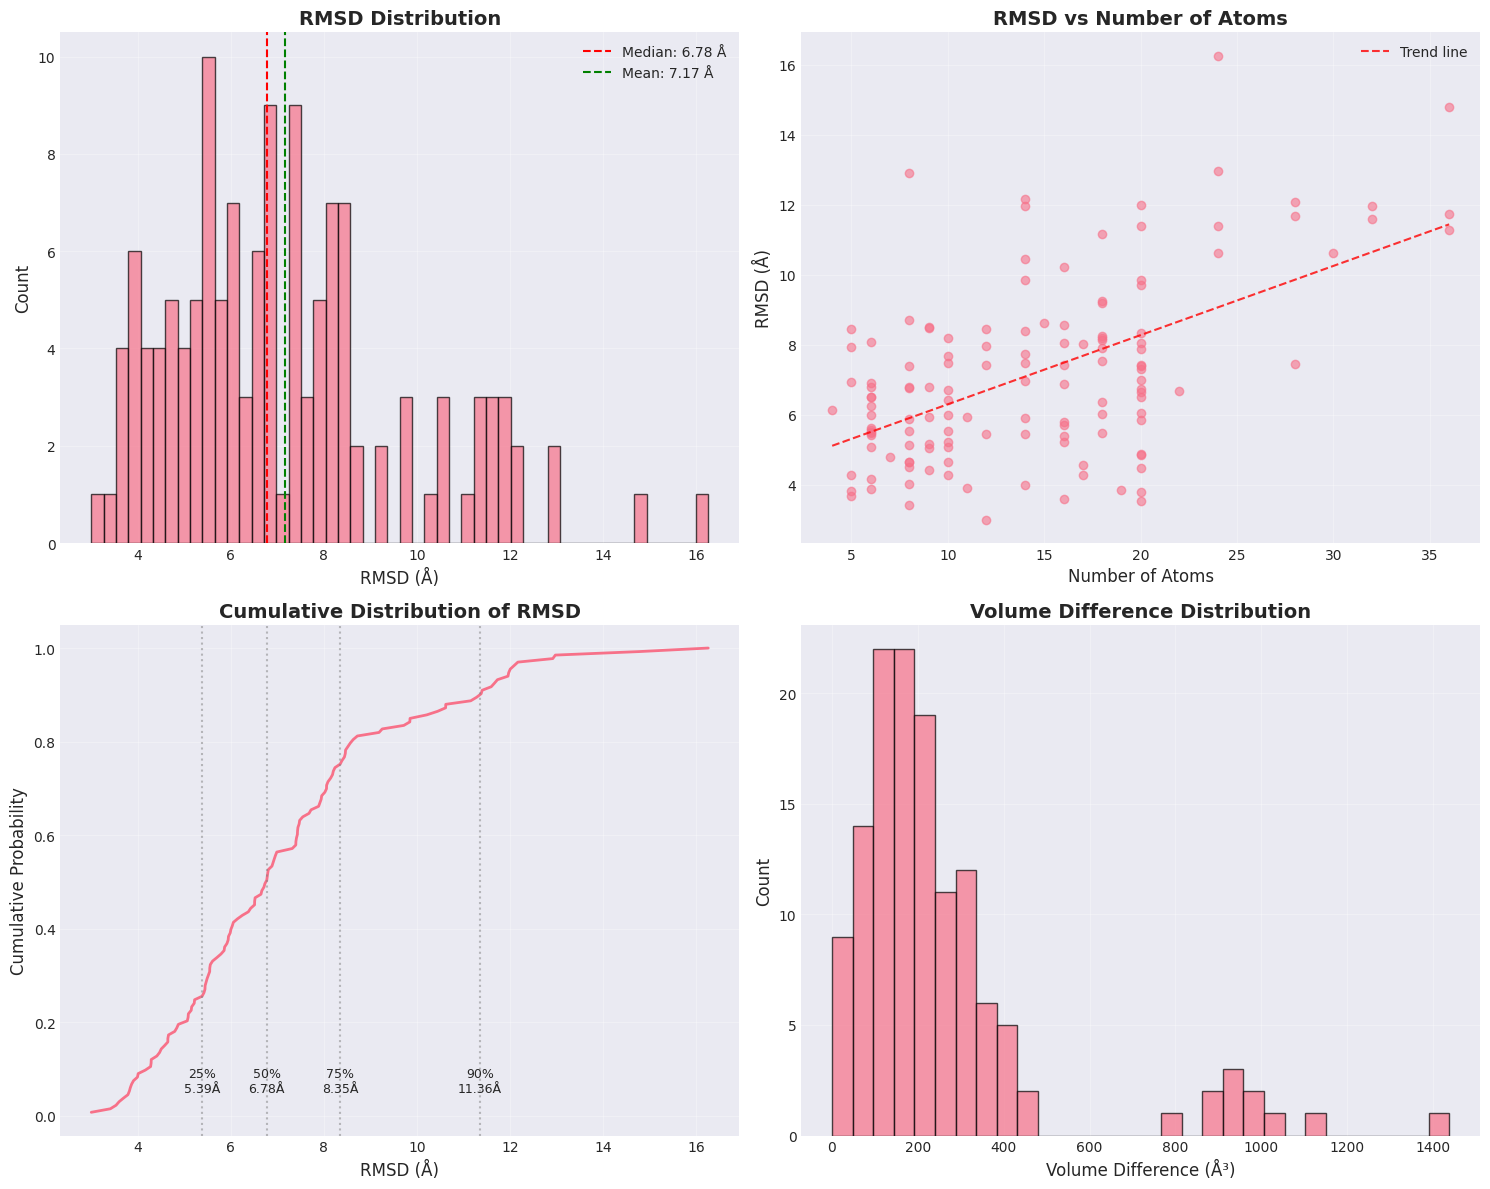

In [34]:
if not rmsd_df.empty and not rmsd_df[rmsd_df['rmsd'] != np.inf].empty:
    valid_rmsd = rmsd_df[rmsd_df['rmsd'] != np.inf]
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. RMSD分布直方图
    ax = axes[0, 0]
    ax.hist(valid_rmsd['rmsd'], bins=50, edgecolor='black', alpha=0.7)
    ax.set_xlabel('RMSD (Å)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('RMSD Distribution', fontsize=14, fontweight='bold')
    ax.axvline(valid_rmsd['rmsd'].median(), color='red', linestyle='--', 
               label=f'Median: {valid_rmsd["rmsd"].median():.2f} Å')
    ax.axvline(valid_rmsd['rmsd'].mean(), color='green', linestyle='--',
               label=f'Mean: {valid_rmsd["rmsd"].mean():.2f} Å')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. RMSD vs 原子数
    ax = axes[0, 1]
    ax.scatter(valid_rmsd['num_atoms'], valid_rmsd['rmsd'], alpha=0.6)
    ax.set_xlabel('Number of Atoms', fontsize=12)
    ax.set_ylabel('RMSD (Å)', fontsize=12)
    ax.set_title('RMSD vs Number of Atoms', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 添加趋势线
    if len(valid_rmsd) > 1:
        z = np.polyfit(valid_rmsd['num_atoms'], valid_rmsd['rmsd'], 1)
        p = np.poly1d(z)
        ax.plot(valid_rmsd['num_atoms'].sort_values(), 
                p(valid_rmsd['num_atoms'].sort_values()), 
                "r--", alpha=0.8, label='Trend line')
        ax.legend()
    
    # 3. 累积分布函数
    ax = axes[1, 0]
    sorted_rmsd = np.sort(valid_rmsd['rmsd'])
    cumulative = np.arange(1, len(sorted_rmsd) + 1) / len(sorted_rmsd)
    ax.plot(sorted_rmsd, cumulative, linewidth=2)
    ax.set_xlabel('RMSD (Å)', fontsize=12)
    ax.set_ylabel('Cumulative Probability', fontsize=12)
    ax.set_title('Cumulative Distribution of RMSD', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 标记关键百分位
    percentiles = [25, 50, 75, 90]
    for p in percentiles:
        val = np.percentile(valid_rmsd['rmsd'], p)
        ax.axvline(val, color='gray', linestyle=':', alpha=0.5)
        ax.text(val, 0.05, f'{p}%\n{val:.2f}Å', 
                rotation=0, ha='center', fontsize=9)
    
    # 4. 体积差异分布
    ax = axes[1, 1]
    if 'volume_diff' in valid_rmsd.columns:
        ax.hist(valid_rmsd['volume_diff'], bins=30, edgecolor='black', alpha=0.7)
        ax.set_xlabel('Volume Difference (Å³)', fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.set_title('Volume Difference Distribution', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'Volume data not available', 
                ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("没有有效数据可视化")

## 7. 最好和最差案例分析

In [35]:
if not rmsd_df.empty:
    valid_rmsd = rmsd_df[rmsd_df['rmsd'] != np.inf]
    
    if not valid_rmsd.empty:
        # 找出最好的预测
        print("="*60)
        print("最佳预测（RMSD最小）")
        print("="*60)
        best_samples = valid_rmsd.nsmallest(5, 'rmsd')
        print(best_samples[['id', 'rmsd', 'num_atoms', 'composition']])
        
        print("\n" + "="*60)
        print("最差预测（RMSD最大）")
        print("="*60)
        worst_samples = valid_rmsd.nlargest(5, 'rmsd')
        print(worst_samples[['id', 'rmsd', 'num_atoms', 'composition']])
        
        # 分析最好和最差样本的特征
        print("\n" + "="*60)
        print("特征对比")
        print("="*60)
        print(f"\n最佳5个样本:")
        print(f"  平均原子数: {best_samples['num_atoms'].mean():.1f}")
        print(f"  平均RMSD: {best_samples['rmsd'].mean():.3f} Å")
        
        print(f"\n最差5个样本:")
        print(f"  平均原子数: {worst_samples['num_atoms'].mean():.1f}")
        print(f"  平均RMSD: {worst_samples['rmsd'].mean():.3f} Å")
    
    # 显示无效预测
    invalid_samples = rmsd_df[rmsd_df['rmsd'] == np.inf]
    if not invalid_samples.empty:
        print("\n" + "="*60)
        print(f"无效预测（无法计算RMSD，共{len(invalid_samples)}个）")
        print("="*60)
        print("前10个无效样本:")
        print(invalid_samples[['id', 'composition']].head(10))

最佳预测（RMSD最小）
         id      rmsd  num_atoms      composition
177   A-424  3.004126         12          As6 Eu6
46   A-1194  3.414935          8  Al1 Au1 Rh4 Zr2
104   A-893  3.536355         20   Ba4 Bi2 O12 Y2
44   A-1372  3.601972         16   Al1 Fe8 Si5 V2
117  A-1153  3.693709          5  Ga1 Ge1 Rh2 Sr1

最差预测（RMSD最大）
         id       rmsd  num_atoms        composition
71    A-967  16.264846         24            Bi6 I18
17   A-1443  14.789238         36  Ho10 Sm8 Sn16 Tb2
80   A-1550  12.979175         24   La6 Li1 Ni2 Rh15
122    A-43  12.923639          8         In3 Pd4 Y1
52    A-823  12.173530         14     Li3 O8 Sb1 Sn2

特征对比

最佳5个样本:
  平均原子数: 12.2
  平均RMSD: 3.450 Å

最差5个样本:
  平均原子数: 21.2
  平均RMSD: 13.826 Å

无效预测（无法计算RMSD，共65个）
前10个无效样本:
        id          composition
1   A-1447        B3 Mg1 N6 Sr4
10   A-454     Al2 Ga3 Ni10 Sm3
14   A-621          F12 Fe2 Li6
16   A-665  Dy8 Ga2 Lu4 Ni2 Os2
20   A-640       F12 Ge2 K2 Rb2
21   A-318      F12 Hg2 Li4 Zn2
22  A-1493 

## 8. 保存评测结果

In [36]:
if not rmsd_df.empty:
    # 保存详细评测结果
    output_file = "evaluation_results.csv"
    rmsd_df.to_csv(output_file, index=False)
    print(f"评测结果已保存到: {output_file}")
    
    valid_rmsd = rmsd_df[rmsd_df['rmsd'] != np.inf]
    
    # 生成评测报告
    report = f"""
================================================================================
                           晶体结构预测评测报告
================================================================================

评测时间: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
总样本数: {len(rmsd_df)}
有效样本数: {len(valid_rmsd)}
无效样本数: {len(rmsd_df) - len(valid_rmsd)}

RMSD统计（有效样本）:
---------
"""
    
    if not valid_rmsd.empty:
        report += f"""
  最小值: {valid_rmsd['rmsd'].min():.4f} Å
  最大值: {valid_rmsd['rmsd'].max():.4f} Å
  平均值: {valid_rmsd['rmsd'].mean():.4f} Å
  中位数: {valid_rmsd['rmsd'].median():.4f} Å
  标准差: {valid_rmsd['rmsd'].std():.4f} Å

成功率:
-------
  RMSD < 0.5 Å: {(valid_rmsd['rmsd'] < 0.5).mean() * 100:.2f}%
  RMSD < 1.0 Å: {(valid_rmsd['rmsd'] < 1.0).mean() * 100:.2f}%
  RMSD < 2.0 Å: {(valid_rmsd['rmsd'] < 2.0).mean() * 100:.2f}%
  RMSD < 5.0 Å: {(valid_rmsd['rmsd'] < 5.0).mean() * 100:.2f}%

最佳预测TOP 3:
-------------
"""
        
        best_3 = valid_rmsd.nsmallest(3, 'rmsd')
        for idx, row in best_3.iterrows():
            report += f"  {row['id']}: RMSD = {row['rmsd']:.4f} Å\n"
    else:
        report += "  没有有效的RMSD结果\n"
    
    report += """
================================================================================
"""
    
    # 保存报告
    with open("evaluation_report.txt", 'w') as f:
        f.write(report)
    
    print(report)
    print("评测报告已保存到: evaluation_report.txt")
else:
    print("没有评测结果可保存")

评测结果已保存到: evaluation_results.csv

                           晶体结构预测评测报告

评测时间: 2025-08-29 12:19:46
总样本数: 198
有效样本数: 133
无效样本数: 65

RMSD统计（有效样本）:
---------

  最小值: 3.0041 Å
  最大值: 16.2648 Å
  平均值: 7.1674 Å
  中位数: 6.7764 Å
  标准差: 2.5842 Å

成功率:
-------
  RMSD < 0.5 Å: 0.00%
  RMSD < 1.0 Å: 0.00%
  RMSD < 2.0 Å: 0.00%
  RMSD < 5.0 Å: 19.55%

最佳预测TOP 3:
-------------
  A-424: RMSD = 3.0041 Å
  A-1194: RMSD = 3.4149 Å
  A-893: RMSD = 3.5364 Å


评测报告已保存到: evaluation_report.txt


## 总结

本notebook完成了：
1. ✅ 加载submission.csv（CIF格式）和ground truth数据
2. ✅ 解析CIF格式晶体结构
3. ✅ 使用StructureMatcher计算RMSD评测指标
4. ✅ 统计分析和可视化
5. ✅ 生成评测报告

**注意事项**：
- CIF格式解析可能失败，需要处理异常情况
- StructureMatcher考虑了对称性，结果更准确
- 可以根据需要添加更多评测指标（如能量、空间群等）